In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import time
import random
from itertools import combinations
from tqdm.notebook import tqdm
import optuna
import math

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.feature_selection import RFECV, mutual_info_classif

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from concurrent.futures import ThreadPoolExecutor
from category_encoders import TargetEncoder

from lightgbm import LGBMClassifier

from pprint import pprint
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

experiment_name = 'lgbm'

In [2]:
train = pd.read_csv('new_combined_train_spear.csv')

train.head()

,FAF_ceil_round,FCVC_ceil_round,TUE_floor_round,TUE_ceil_round,CH2O_floor_round,FAF_floor_round,CH2O_ceil_round,FCVC_round,NCP_ceil_round,FAF_round,FCVC_floor_round,TUE_round,CH2O_round,NCP_floor_round,Weight_2dec,Height_2dec,Automobile,Bike,Motorbike,Walking,CALC_map,family_history_with_overweight_map,CAEC_map,SCC_map,Gender_map,FAVC_map,SMOKE_map,CALC,CAEC,Weight_2dec_gt_Height_2dec,Weight_2dec_gt_Gender,Weight_2dec_div_CALC,Weight_2dec_gt_CALC,Weight_2dec_div_CAEC,Weight_2dec_gt_CAEC,Weight_2dec_gt_MTRANS,Weight_2dec_div_family_history_with_overweight,Weight_2dec_gt_family_history_with_overweight,Weight_2dec_div_FAVC,Weight_2dec_gt_FAVC,Weight_2dec_gt_SMOKE,Weight_2dec_div_SCC,Weight_2dec_gt_SCC,Height_2dec_x_Gender,Height_2dec_plus_Gender,Height_2dec_gt_Gender,Height_2dec_x_CALC,Height_2dec_minus_CALC,Height_2dec_gt_CALC,Height_2dec_x_CAEC,Height_2dec_minus_CAEC,Height_2dec_x_MTRANS,Height_2dec_minus_MTRANS,Height_2dec_x_family_history_with_overweight,Height_2dec_minus_family_history_with_overweight,Height_2dec_x_FAVC,Height_2dec_minus_FAVC,Height_2dec_gt_FAVC,Height_2dec_gt_SMOKE,Gender_x_CALC,Gender_minus_CALC,Gender_x_CAEC,Gender_minus_CAEC,Gender_minus_MTRANS,Std_Gender_MTRANS,Gender_x_family_history_with_overweight,Gender_minus_family_history_with_overweight,Gender_x_FAVC,Gender_minus_FAVC,Gender_x_SCC,CALC_x_CAEC,CALC_minus_CAEC,CALC_x_MTRANS,CALC_minus_MTRANS,CALC_x_family_history_with_overweight,CALC_minus_family_history_with_overweight,CALC_x_FAVC,CALC_minus_FAVC,CAEC_x_MTRANS,CAEC_minus_MTRANS,CAEC_x_family_history_with_overweight,CAEC_minus_family_history_with_overweight,CAEC_div_family_history_with_overweight,Std_CAEC_family_history_with_overweight,CAEC_gt_family_history_with_overweight,CAEC_x_FAVC,CAEC_minus_FAVC,MTRANS_x_family_history_with_overweight,MTRANS_minus_family_history_with_overweight,MTRANS_x_FAVC,MTRANS_minus_FAVC,Std_MTRANS_SMOKE,MTRANS_x_SCC,MTRANS_minus_SCC,Std_family_history_with_overweight_SCC,FAVC_x_SCC,FAVC_minus_SCC,SMOKE_x_SCC,SMOKE_minus_SCC,Weight_2dec_div_prod_of_CALC_and_CAEC,Weight_2dec_div_prod_of_CALC_and_family_history_with_overweight,Weight_2dec_div_prod_of_CALC_and_FAVC,Weight_2dec_div_prod_of_CALC_and_SCC,Weight_2dec_div_sum_of_CAEC_and_family_history_with_overweight,Weight_2dec_div_prod_of_CAEC_and_family_history_with_overweight,CAEC_div_prod_of_Weight_2dec_and_family_history_with_overweight,family_history_with_overweight_div_prod_of_Weight_2dec_and_CAEC,Weight_2dec_div_prod_of_CAEC_and_FAVC,Height_2dec_x_Gender_x_CALC,CALC_div_prod_of_Height_2dec_and_Gender,Height_2dec_plus_Gender_minus_CAEC,Height_2dec_plus_Gender_plus_CAEC,Height_2dec_x_Gender_x_CAEC,CAEC_div_prod_of_Height_2dec_and_Gender,Std_of_Height_2dec_Gender_CAEC,Height_2dec_plus_Gender_minus_MTRANS,Height_2dec_plus_Gender_plus_MTRANS,Height_2dec_x_Gender_x_MTRANS,MTRANS_div_prod_of_Height_2dec_and_Gender,Height_2dec_plus_Gender_minus_family_history_with_overweight,Height_2dec_plus_Gender_plus_family_history_with_overweight,Height_2dec_x_Gender_x_family_history_with_overweight,family_history_with_overweight_div_prod_of_Height_2dec_and_Gender,Height_2dec_plus_Gender_minus_FAVC,Height_2dec_plus_Gender_plus_FAVC,Height_2dec_x_Gender_x_FAVC,FAVC_div_prod_of_Height_2dec_and_Gender,Gender_plus_SCC_minus_Height_2dec,Height_2dec_plus_CALC_minus_CAEC,Height_2dec_plus_CAEC_minus_CALC,CALC_plus_CAEC_minus_Height_2dec,Height_2dec_plus_CALC_plus_CAEC,Height_2dec_plus_MTRANS_minus_CALC,Height_2dec_plus_CALC_minus_family_history_with_overweight,Height_2dec_plus_family_history_with_overweight_minus_CALC,CALC_plus_family_history_with_overweight_minus_Height_2dec,Height_2dec_plus_CALC_plus_family_history_with_overweight,Height_2dec_plus_CALC_minus_FAVC,Height_2dec_plus_FAVC_minus_CALC,CALC_plus_FAVC_minus_Height_2dec,Height_2dec_plus_MTRANS_minus_CAEC,Height_2dec_plus_CAEC_plus_MTRANS,Height_2dec_plus_CAEC_minus_family_history_with_overweight,Height_2dec_plus_family_history_with_overweight_minus_CAEC,CAEC_plus_family_history_with_over

In [3]:
TARGET = 'NObeyesdad'

In [4]:
sfs_features = ['Weight_2dec',
                    'FCVC_floor_round+Public_Transportation',
                    'Age_ceil_round+Age_round',
                    'Weight_2dec_div_SCC',
                    'Gender_plus_SCC_minus_Height_2dec',
                    'Height_2dec_minus_FAVC',
                    'Height_2dec',
                    'Std_Gender_MTRANS',
                    'FCVC_ceil_round+Gender_map',
                    'Height_2dec_minus_CAEC',
                    'CAEC_div_prod_of_Weight_2dec_and_family_history_with_overweight',
                    'FAF_ceil_round+NCP_ceil_round',
                    'FAF_ceil_round+CH2O_round',
                    'CH2O_floor_round+CAEC_map',
                    'TUE_floor_round+FCVC_floor_round',
                    'NCP_floor_round+Gender_map',
                    'TUE_floor_round+FAF_floor_round',
                    'CH2O_ceil_round+FCVC_round',
                    'FAF_ceil_round+TUE_round',
                    'FAF_ceil_round',
                    'CALC_div_prod_of_Height_2dec_and_Gender',
                    'Height_2dec_plus_CAEC_minus_family_history_with_overweight',
                    'Height_2dec_plus_CALC_minus_CAEC',
                    'FCVC_round+NCP_ceil_round',
                    'Height_2dec_plus_CAEC_plus_MTRANS',
                    'NObeyesdad']

In [5]:
X = train[sfs_features]
y = train[TARGET]

In [6]:
# Calculate the correlation matrix
corr = X.corr()

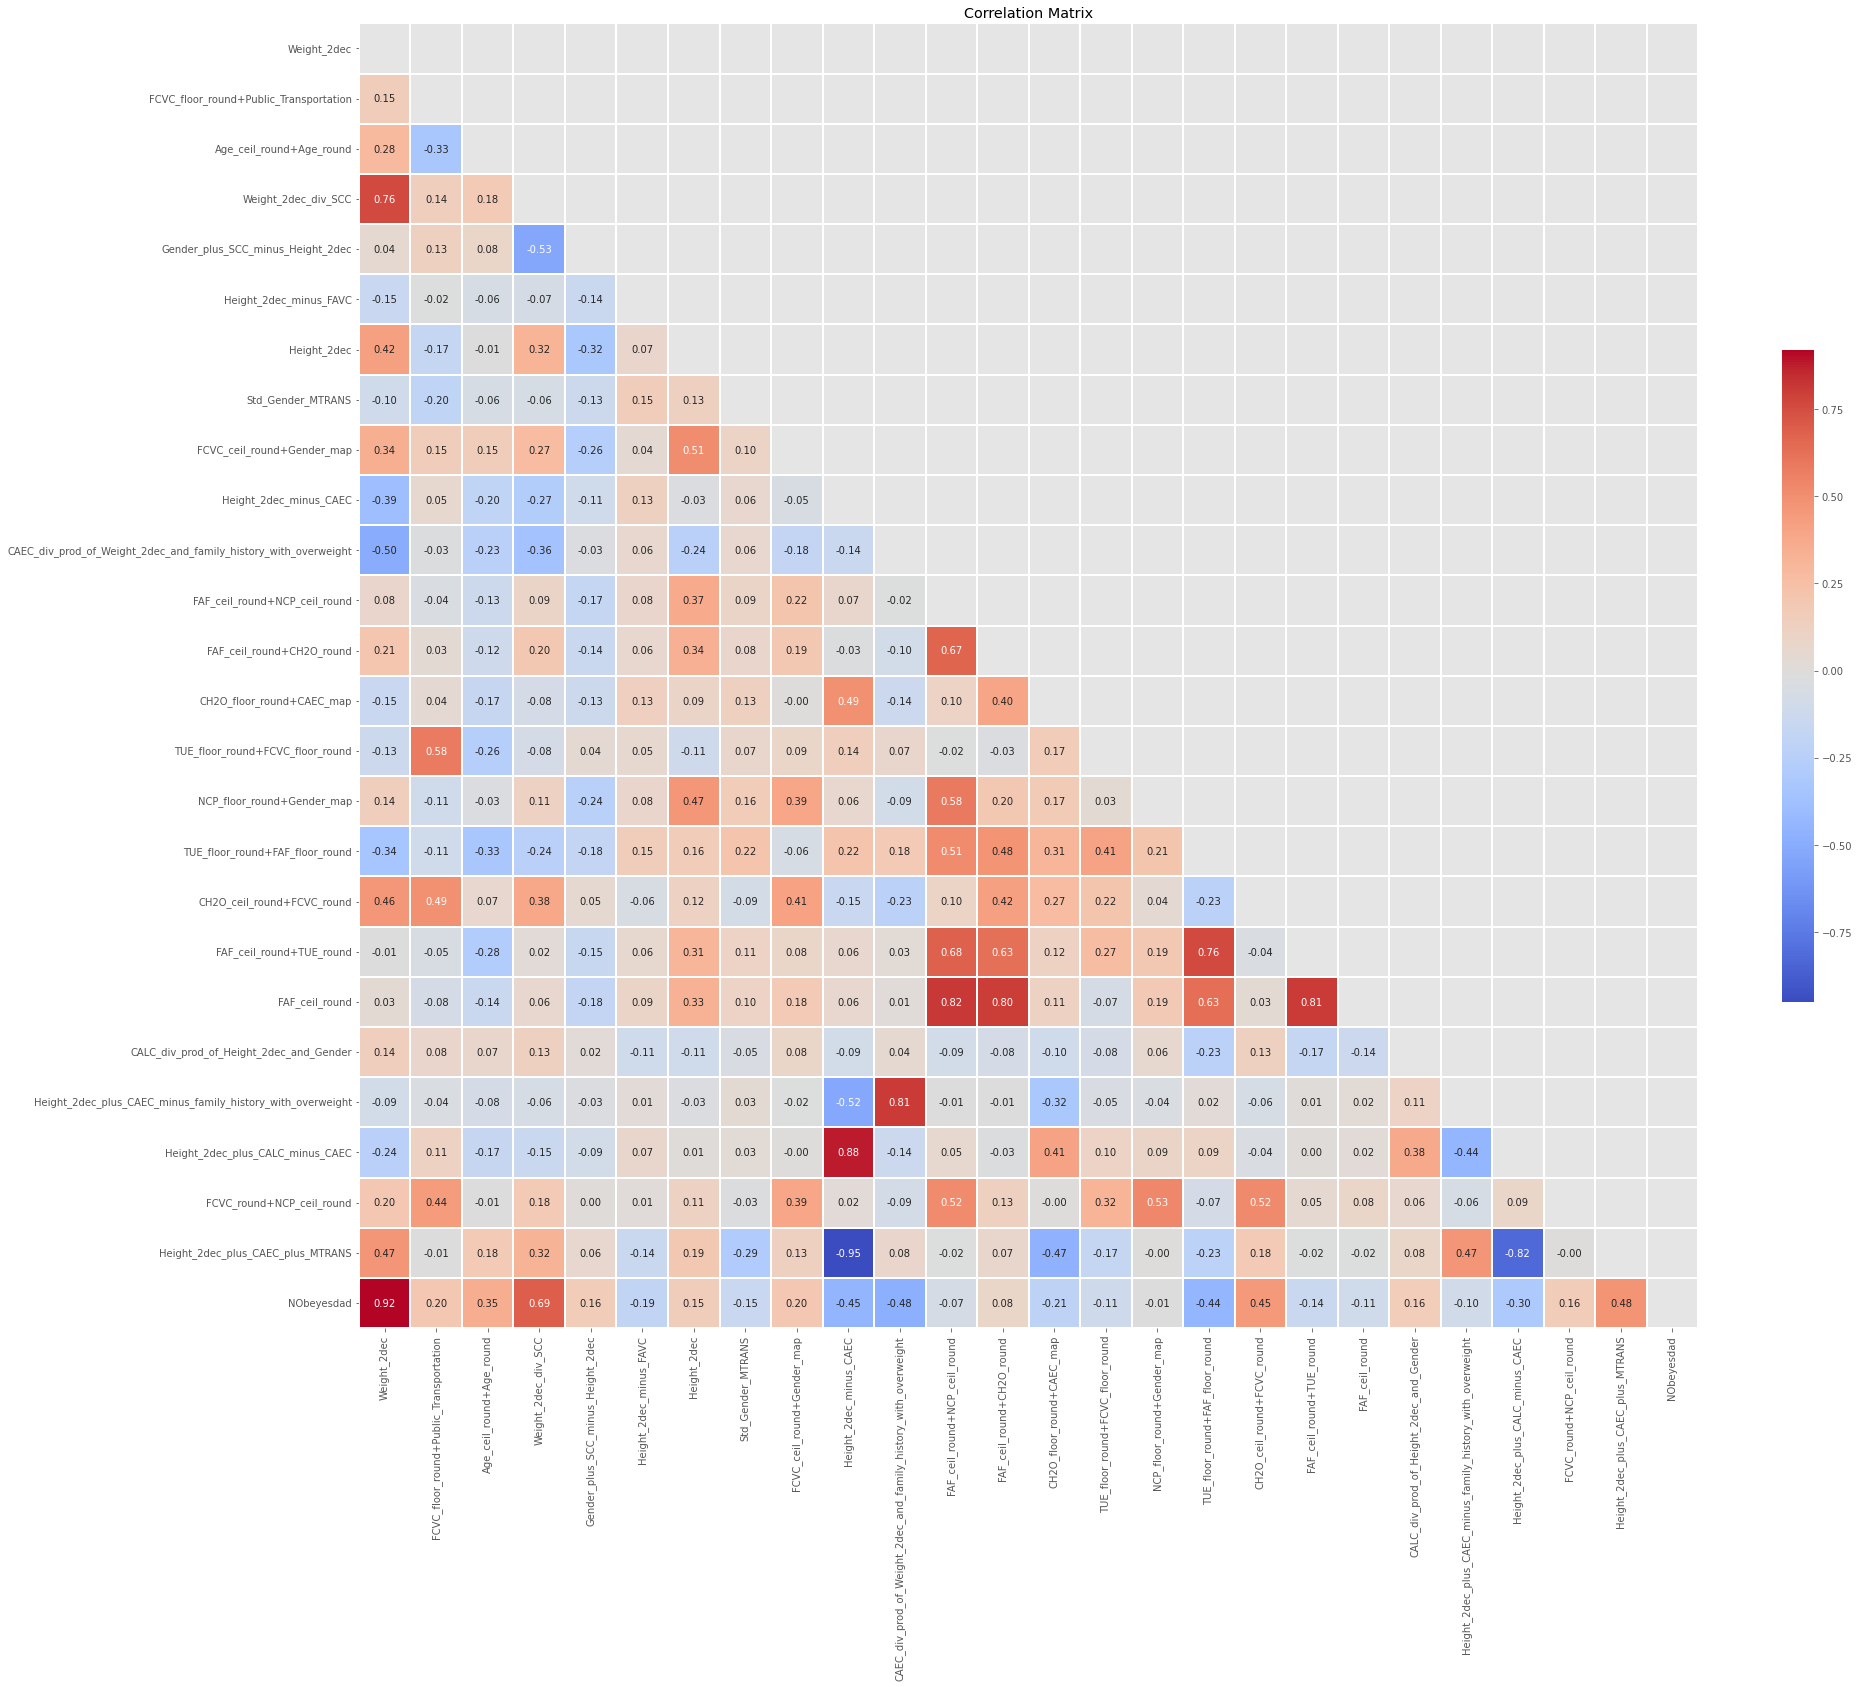

In [8]:
# Generate a mas for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(30, 24))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.05, cbar_kws={'shrink': .5})
plt.title('Correlation Matrix')
plt.show()